In [1]:
import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.models.plr_ash import PenalizedMrASH as PenMrASH
from mrashpen.models.normal_means_ash import NormalMeansASH

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 0.05):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    prior_grid = (np.arange(k) * 5) + 0.1
    prior_grid *= scale
    return w, prior_grid

In [2]:
n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k)
dj     = np.sum(np.square(X), axis = 0)

In [3]:
def elbo_nm_1d(z, s, wk, sk):
    s2 = s * s
    nmash = NormalMeansASH(np.array([z]), s, wk, sk, debug = False)
    phik, muk, vark = nmash.posterior()
    mbar  = np.sum(phik * muk)
    m2bar = np.sum(phik * (muk * muk + vark))
    t1 = - 0.5 * np.log(2 * np.pi * s2)
    t2 = - 0.5 * np.square(z - mbar) / s2
    t3 = - 0.5 * (mbar * mbar + m2bar) / s2
    t4 = - np.sum(phik[:, 1:] * np.log(phik[:, 1:] / wk[1:]))
    _sk2 = np.square(sk)[1:]
    _m2  = (muk * muk + vark)[:, 1:]
    t5 = 0.5 * np.sum(phik[:, 1:] * (1 + np.log(vark[:, 1:] / _sk2)  - _m2 / _sk2))
    elbo = t1 + t2 + t3 + t4 + t5
    return elbo

def elbo_nm(zarr, sarr, wk, sk):
    elbo = np.zeros_like(zarr)
    p = zarr.shape[0]
    for i in range(p):
        elbo[i] = elbo_nm_1d(zarr[i], sarr[i], wk, sk)
    return elbo

In [4]:
def mrash_elbo_nm(X, y, b, s, wk, sk, dj = None):
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    '''
    Precalculate
    '''
    n, p   = X.shape
    s2     = s * s
    bbar   = b.copy()
    rbar   = y - np.dot(X, bbar)
    btilde = bbar + np.dot(X.T, rbar) / dj
    '''
    The terms in ELBO
    '''
    t1     = - 0.5 * (n - p) * np.log(2 * np.pi * s2)
    t2     = - 0.5 * np.dot(rbar.T, rbar) / s2
    t3     = 0.5 * np.sum(np.square(btilde - bbar) * dj / s2)
    t4     = np.sum(elbo_nm(btilde, np.sqrt(s2 / dj), wk, sk))
    t5     = - 0.5 * np.sum(np.log(dj))
    elbo   = t1 + t2 + t3 + t4 + t5
    return elbo, t1, t2, t3, t4, t5

def mrash_elbo_direct(X, y, b, s, wk, sk, dj = None):
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    '''
    Precalculate
    '''
    n, p   = X.shape
    s2     = s * s
    bbar   = b.copy()
    rbar   = y - np.dot(X, bbar)
    btilde = bbar + np.dot(X.T, rbar) / dj
    sk2 = np.square(sk)
    '''
    NM posterior phijk, mujk, vjk
    '''
    phijk = np.zeros((p, k))
    mujk  = np.zeros((p, k))
    vjk2  = np.zeros((p, k))
    for j in range(p):
        z = np.array([btilde[j]])
        nmash = NormalMeansASH(z, np.sqrt(s2 / dj[j]), wk, sk, debug = False)
        phik, muk, vk2 = nmash.posterior()
        phijk[j, :] = phik
        mujk[j, :] = muk
        vjk2[j, :] = vk2
    mujk2 = np.square(mujk)
    '''
    The terms in ELBO
    '''
    t1     = - 0.5 * n * np.log(2 * np.pi * s2)
    t2     = - 0.5 * np.dot(rbar.T, rbar) / s2
    t3     = - 0.5 * np.sum(dj * (np.sum(phijk * (mujk * mujk + vjk2), axis = 1) - (bbar * bbar))) / s2
    t4     = - np.sum(phijk[:, 1:] * np.log(phijk[:, 1:] / wk[1:]))
    t5     = 0.5 * np.sum(phijk[:, 1:] * \
                          (1 + np.log(vjk2[:, 1:] / sk2[1:]) - (mujk2[:, 1:] + vjk2[:, 1:]) / sk2[1:]))
    elbo   = t1 + t2 + t3 + t4 + t5
    return elbo, t1, t2, t3, t4, t5


def mrash_elbo2(X, y, b, s, wk, sk, dj = None):
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    s2     = s * s
    bbar   = b.copy()
    rbar   = y - np.dot(X, bbar)
    erss   = np.dot(rbar.T, rbar)
    t1     = - 0.5 * n * np.log(2 * np.pi * s2)
    t2     = - 0.5 * erss / s2
    elbo   = t1 + t2
    return elbo, t1, t2, 0, 0, 0

def mrash_elbo3(X, y, b, s, wk, sk, dj = None):
    if dj is None: dj = np.sum(np.square(X), axis = 0)
    s2     = s * s
    bbar   = b.copy()
    rbar   = y - np.dot(X, bbar)
    erss   = np.dot(rbar.T, rbar)
    t1     = - 0.5 * n * np.log(2 * np.pi * s2)
    t2     = - 0.5 * erss / s2
    elbo   = t1 + t2
    return elbo, t1, t2, 0, 0, 0    

In [5]:
mrash_elbo_nm(X, y, btrue, strue, wk, sk, dj = dj)

(-5337.092516470875,
 3916.006849112626,
 -102.9787123964849,
 1034.8788835758894,
 -4886.68217021487,
 -5298.317366548035)

In [9]:
mrash_elbo_direct(X, y, btrue, strue, wk, sk, dj = dj)

(-5104.670693428684,
 -435.11187212362506,
 -102.9787123964849,
 -1712.7190784818342,
 -578.4908514421909,
 -2275.370178984549)

In [10]:
mrash_elbo2(X, y, btrue, strue, wk, sk, dj = dj)

(-538.0905845201099, -435.11187212362506, -102.9787123964849, 0, 0, 0)

In [11]:
sigma2seq = np.logspace(-1, 3, 50)
sigma2seq

array([1.00000000e-01, 1.20679264e-01, 1.45634848e-01, 1.75751062e-01,
       2.12095089e-01, 2.55954792e-01, 3.08884360e-01, 3.72759372e-01,
       4.49843267e-01, 5.42867544e-01, 6.55128557e-01, 7.90604321e-01,
       9.54095476e-01, 1.15139540e+00, 1.38949549e+00, 1.67683294e+00,
       2.02358965e+00, 2.44205309e+00, 2.94705170e+00, 3.55648031e+00,
       4.29193426e+00, 5.17947468e+00, 6.25055193e+00, 7.54312006e+00,
       9.10298178e+00, 1.09854114e+01, 1.32571137e+01, 1.59985872e+01,
       1.93069773e+01, 2.32995181e+01, 2.81176870e+01, 3.39322177e+01,
       4.09491506e+01, 4.94171336e+01, 5.96362332e+01, 7.19685673e+01,
       8.68511374e+01, 1.04811313e+02, 1.26485522e+02, 1.52641797e+02,
       1.84206997e+02, 2.22299648e+02, 2.68269580e+02, 3.23745754e+02,
       3.90693994e+02, 4.71486636e+02, 5.68986603e+02, 6.86648845e+02,
       8.28642773e+02, 1.00000000e+03])

In [12]:
strue * strue

12.344883118460732

In [16]:
elboseq    = np.zeros_like(sigma2seq)
elbot1seq  = np.zeros_like(sigma2seq)
elbot2seq  = np.zeros_like(sigma2seq)
elbot3seq  = np.zeros_like(sigma2seq)
elbot4seq  = np.zeros_like(sigma2seq)
elbot5seq  = np.zeros_like(sigma2seq)

for i, sigma2 in enumerate(sigma2seq):
    sigma = np.sqrt(sigma2)
    elbo, t1, t2, t3, t4, t5 = mrash_elbo_nm(X, y, btrue, sigma, wk, sk, dj = dj)
    elboseq[i]    = elbo
    elbot1seq[i]  = t1
    elbot2seq[i]  = t2
    elbot3seq[i]  = t3
    elbot4seq[i]  = t4
    elbot5seq[i]  = t5

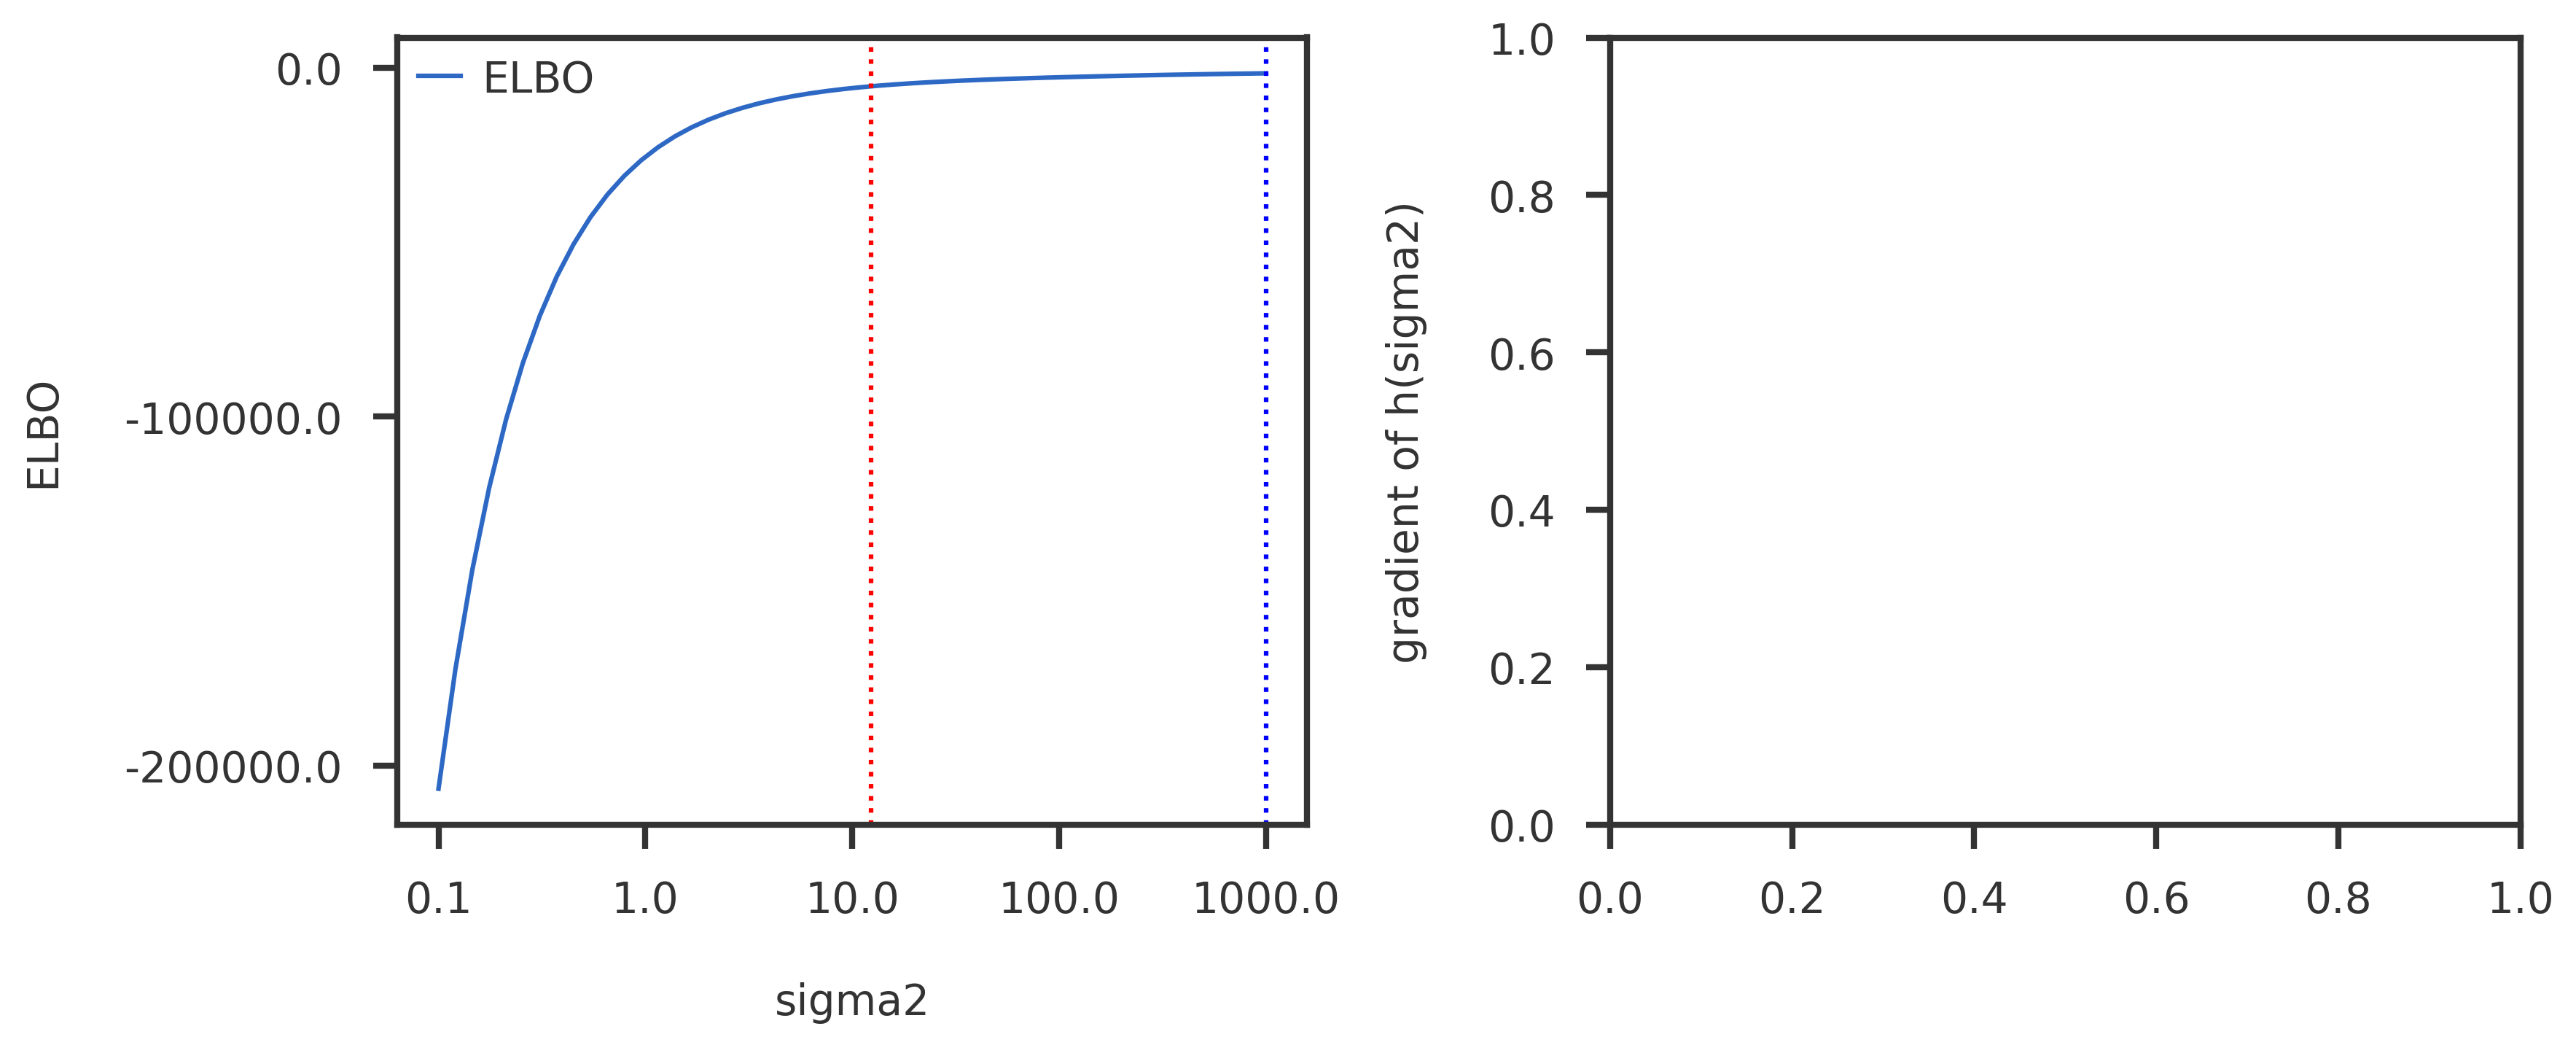

In [17]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xscale = 'log10'
yscale = 'linear'
# for xdata, xlegend in zip([elboseq, elbot1seq, elbot2seq, elbot3seq, elbot4seq, elbot5seq], 
#                           ['ELBO', 't1', 't2', 't3', 't4', 't5']):
for xdata, xlegend in zip([elboseq], 
                          ['ELBO']):
    ax1.plot(mpl_utils.scale_array(sigma2seq, xscale), 
             mpl_utils.scale_array(xdata, yscale),
             label = xlegend
            )
# ax2.plot(mpl_utils.scale_array(sigma2seq, xscale),
#          mpl_utils.scale_array(s2gradseq, yscale))
# mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
for ax in [ax1]:
    mpl_utils.set_xticks(ax, scale = xscale, spacing = xscale)
    mpl_utils.set_yticks(ax, scale = yscale, spacing = yscale)
    ax.axvline(x = mpl_utils.scale_array(np.array([strue * strue]), xscale)[0], color = 'red', ls = 'dotted')
    ax.axvline(x = mpl_utils.scale_array(np.array([sigma2seq[np.argmax(elboseq)]]), xscale)[0], 
               color = 'blue', ls = 'dotted')
    ax.set_xlabel("sigma2")
ax1.set_ylabel("ELBO")
ax2.set_ylabel("gradient of h(sigma2)")
ax1.legend()
plt.tight_layout()
plt.show()

In [12]:
rbar = y - np.dot(X, btrue)
np.dot(rbar.T, rbar) / X.shape[0]

12.712601682241893